# Criando modelos com Python e Machine Learning para prever a evolução do COVID-19 no Brasil



# Libs

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import re


from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


from pmdarima.arima import auto_arima

# Dataset

In [29]:
df= pd.read_csv("covid_19_data.csv", parse_dates=['ObservationDate', 'Last Update'])
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


In [30]:
df.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

In [31]:
df.columns

Index(['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered'],
      dtype='object')

# Tratar base de dados

In [32]:
#Corrigir todas as colunas com pontos e caracteres especiais
def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

In [33]:
df.columns = [corrige_colunas(col) for col in df.columns]
df

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


# Data Analisys

In [34]:
df.loc[df.countryregion == 'Brazil']

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
82,83,2020-01-23,NaN,Brazil,2020-01-23 17:00:00,0.0,0.0,0.0
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0


In [35]:
brasil = df.loc[
  (df.countryregion == 'Brazil') & (df.confirmed > 0)   
]

Casos confirmados 

In [37]:
px.line(brasil, 'observationdate', 'confirmed', 
        labels={'observationdate':'Data', 'confirmed':'Número de casos confirmados'},
       title='Casos confirmados no Brasil')

# Novos Casos por Dia

In [65]:
brasil['novoscasos'] = list(map(
    lambda x: 0 
    if (x==0) 
    else brasil['confirmed'].iloc[x] - brasil['confirmed'].iloc[x-1],
    np.arange(brasil.shape[0])
))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
px.line(brasil, x='observationdate', y='novoscasos', title='Novos casos por diários',
       labels={'observationdate': 'Datas', 'novoscasos': 'Novos Casos'})

In [40]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=brasil.observationdate, y=brasil.deaths, name = "Mortes",
               mode="lines+markers")
)

fig.update_layout(title="Mortes por COVID-19 no Brasil")
fig.show()

In [68]:

# taxa_crescimento = (presente/passado)**(1/n ) -1

In [69]:
#Se a data inicio for None, definir como a primeira data disponível.
# esse pd.to_datetime transforma a variavel em datetime


def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):

    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
    
    if data_fim ==None:
        data_fim = data.observationdate.iloc[-1]
    else: 
        data_fim = pd.to_datetime(data_fim)

#Definir os valores Presente e Passado

    passado  = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]


# Definir o número de pontos no tempo que vamos avaliar

    n = (data_fim - data_inicio).days
    
#Calcular a Taxa 

    taxa = (presente/passado)**(1/n) - 1
    return taxa*100

In [70]:
taxa_crescimento (brasil, "confirmed")

16.27183353112116

In [60]:
def taxa_crescimento_diaria(data, variable, data_inicio=None):
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.max()
    n = (data_fim - data_inicio).days
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1,n+1)
    ))
    return np.array(taxas) * 100

In [61]:
tx_dia =taxa_crescimento_diaria(brasil, 'confirmed')

In [18]:
tx_dia

array([  0.        ,   0.        , 100.        ,   0.        ,
         0.        ,   0.        , 100.        ,   0.        ,
       225.        ,   0.        ,  53.84615385,  25.        ,
        24.        ,  22.58064516,  36.84210526, 190.38461538,
         0.        ,   7.28476821,  23.45679012,  60.5       ,
        15.88785047,  66.93548387,  27.69726248,  28.75157629,
        51.4201763 ,  24.45019405,  16.78794179,  13.66266133,
        16.87548943,  14.47236181,  14.25226807,   9.01639344,
         7.58928571,  24.8525879 ,  19.57320273,  17.67115272,
        12.58080557,  14.39929329,   7.43243243,   9.26325247,
        15.40169394,  15.22017956,  11.88620903,   8.54521335,
         5.54537122,   7.06807546,   5.57858688,   7.81903542,
        12.10513815,   7.4329096 ,  10.70501233,   8.83557983,
         5.44492335,   5.4043566 ,   5.73350023,   6.21648599,
         9.35157462,   8.00823407,   9.77184834,   6.36504619,
         6.88748019,   8.58316283,   8.80726429,   9.41

In [62]:
primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()

px.line(x=pd.date_range(primeiro_dia, brasil.observationdate.max())[1:],
       y=tx_dia, title = 'Taxa de crescimento de casos confirmados no Brasil'       
       )

# Predição de novos casos confirmados 

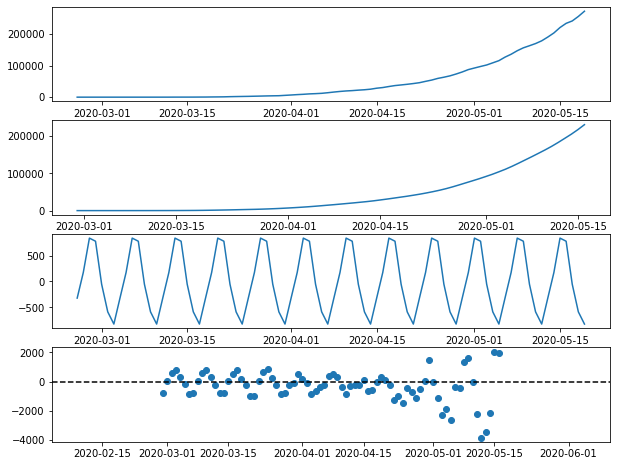

In [63]:

# observados, tendência, sazonalidade e o ruído.
confirmados = brasil.confirmed
confirmados.index = brasil.observationdate

#decompodo
res = seasonal_decompose(confirmados)

#definindo a estrutura do gráfico


fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(confirmados.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

# Predição de Casos Confirmados

 Serão realizadas previsões de casos confirmados no Brasil

- Será utilizado o modelo ARIMA

In [64]:
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='Observed'
))

fig.add_trace(go.Scatter(x=confirmados.index, y = modelo.predict_in_sample(), name='Predicted'))

fig.add_trace(go.Scatter(x=pd.date_range('2020-05-20', '2020-06-05'), y=modelo.predict(15), name='Forecast'))

fig.update_layout(title='Previsão de casos confirmados para os próximos 15 dias',
                 yaxis_title='Casos confirmados', xaxis_title='Data')
fig.show()